### CMM704 – Coursework
#### Semester 2 - 2025

Name  : Nithin Kolamunna |
IIT ID: 20231720 |
RGU ID: 2330844




In [3]:
# Libraries

import pandas as pd
import seaborn as se
from google.colab import drive
import matplotlib.pyplot as mat
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from xgboost import XGBRegressor


In [4]:
# Mount the Google Drive and load the data set
drive.mount('/content/drive')
data =pd.read_csv('/content/drive/MyDrive/ColabNotebooks/DataMining/CourseWork/Dataset_Q1/ds_salaries.csv')

# check basic information about the data set

# Basic info about dataset
print("Basic Information:")
print(data.info)

# Displaying first 10 rows
print("\nFirst 10 Rows:")
print(data.head(n=10))

# replace empty strings
data.replace('', np.nan, inplace=True)

Mounted at /content/drive
Basic Information:
<bound method DataFrame.info of       work_year experience_level employment_type                 job_title  \
0          2023               SE              FT  Principal Data Scientist   
1          2023               MI              CT               ML Engineer   
2          2023               MI              CT               ML Engineer   
3          2023               SE              FT            Data Scientist   
4          2023               SE              FT            Data Scientist   
...         ...              ...             ...                       ...   
3750       2020               SE              FT            Data Scientist   
3751       2021               MI              FT  Principal Data Scientist   
3752       2020               EN              FT            Data Scientist   
3753       2020               EN              CT     Business Data Analyst   
3754       2021               SE              FT      Data Scienc

# Exploratory Data Analysis (EDA)

<ipython-input-5-8f91b070c262>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  se.barplot(x  = missing_counts.index,


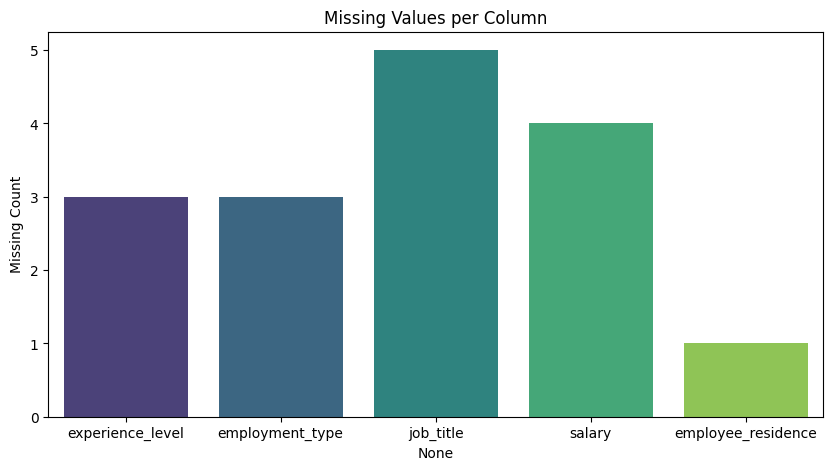

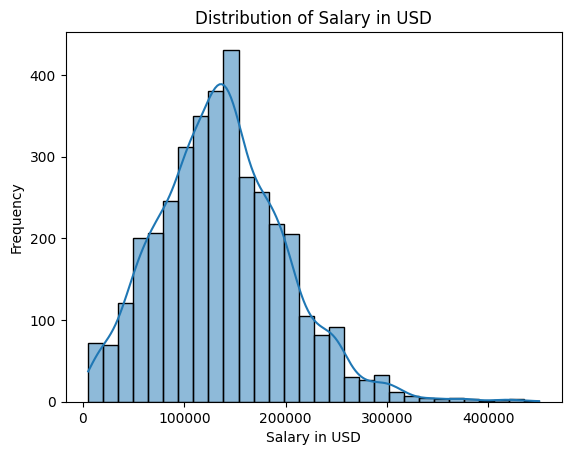

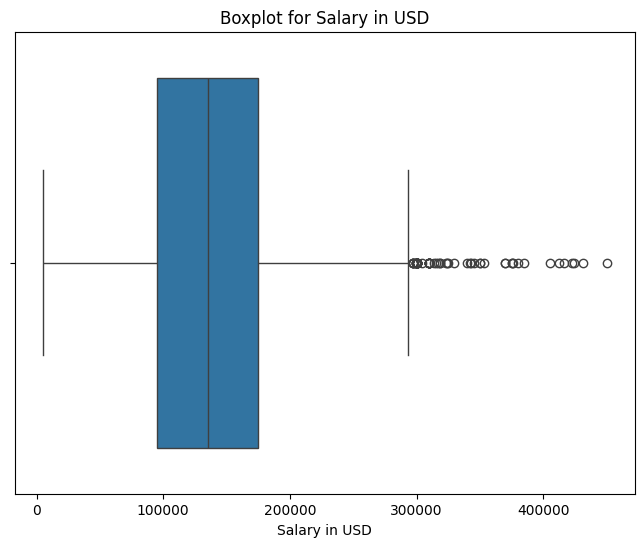

In [5]:
# Visualize missing values
missing_counts = data.isnull().sum() # Null count
missing_counts = missing_counts[missing_counts > 0]  # Keep only null having columns

mat.figure(figsize=(10, 5))
se.barplot(x  = missing_counts.index,
           y  = missing_counts.values,
           palette='viridis'
           )
mat.ylabel('Missing Count')
mat.title('Missing Values per Column')
mat.show()
print("\n")

# Visualize the distribution of the salary_in_usd
se.histplot(data['salary_in_usd'], bins=30, kde=True)
mat.title('Distribution of Salary in USD')
mat.xlabel('Salary in USD')
mat.ylabel('Frequency')
mat.show()
print("\n")

# Boxplot to identify outliers in salary_in_usd
plt.figure(figsize=(8, 6))
se.boxplot(x=data['salary_in_usd'])
mat.title('Boxplot for Salary in USD')
mat.xlabel('Salary in USD')
mat.show()


### EDA Observations


1.   Missing Values:
  * The barplot confirms missing values in the columns.


2.   Salary Distribution:
  * The salary distribution is uneven, with a few very high-paying salaries.

# Missing Values Imputaion

In [6]:
# Fix missing values with the mode for categorical variables and median for numerical

data['experience_level'].fillna(data['experience_level'].mode()[0], inplace=True)
data['employment_type'].fillna(data['employment_type'].mode()[0], inplace=True)
data['job_title'].fillna(data['job_title'].mode()[0], inplace=True)
data['employee_residence'].fillna(data['employee_residence'].mode()[0], inplace=True)

data['salary'].fillna(data['salary'].median(), inplace=True)


# Check missing values remain
print(data.isnull().sum())

work_year             0
experience_level      0
employment_type       0
job_title             0
salary                0
salary_currency       0
salary_in_usd         0
employee_residence    0
remote_ratio          0
company_location      0
company_size          0
dtype: int64


<ipython-input-6-041506e160d4>:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['experience_level'].fillna(data['experience_level'].mode()[0], inplace=True)
<ipython-input-6-041506e160d4>:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(

# Outlier Detection and Removal

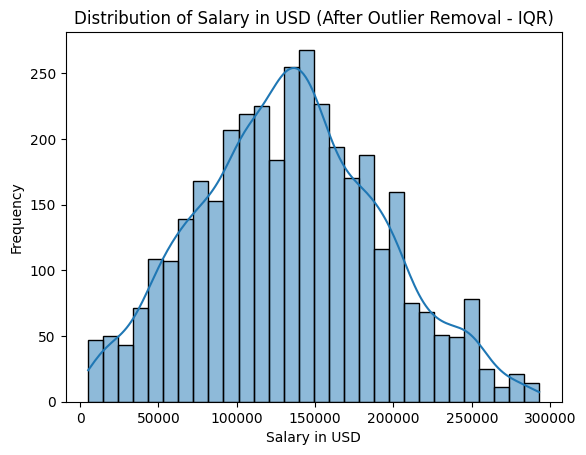

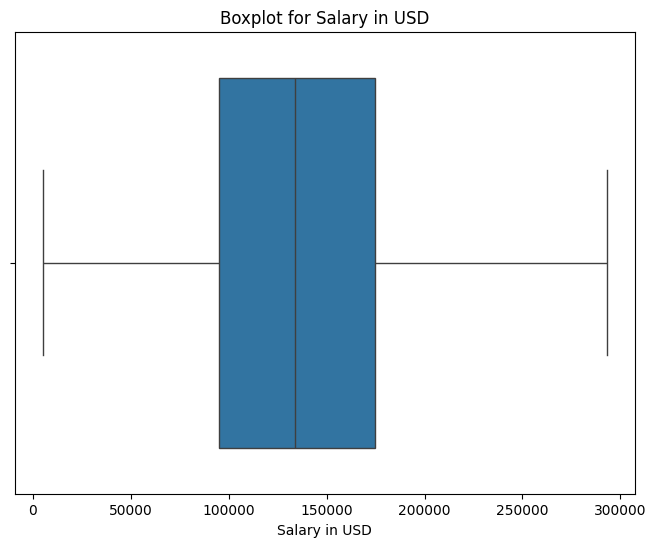

In [7]:
#using IQR

Q1 = data['salary_in_usd'].quantile(0.25)
Q3 = data['salary_in_usd'].quantile(0.75)
IQR = Q3 - Q1

#Set Outlier boundaries
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# remove the outliers
data = data[(data['salary_in_usd'] >= lower_bound) & (data['salary_in_usd'] <= upper_bound)]


# Visualize the distribution of the salary_in_usd after outlier removal
se.histplot(data['salary_in_usd'], bins=30, kde=True)
mat.title('Distribution of Salary in USD (After Outlier Removal - IQR)')
mat.xlabel('Salary in USD')
mat.ylabel('Frequency')
mat.show()
print("\n")


# Boxplot to identify outliers in salary_in_usd
plt.figure(figsize=(8, 6))
se.boxplot(x=data['salary_in_usd'])
mat.title('Boxplot for Salary in USD')
mat.xlabel('Salary in USD')
mat.show()

### Observations

1.   Missing Values:
  * All missing values have been successfully imputed by using mode and median


2.   Outlier Removal:
  * Outliers were removed using the IQR method.
  * Salary distribution is now more normalized and it will improve the model.




# Feature Selection

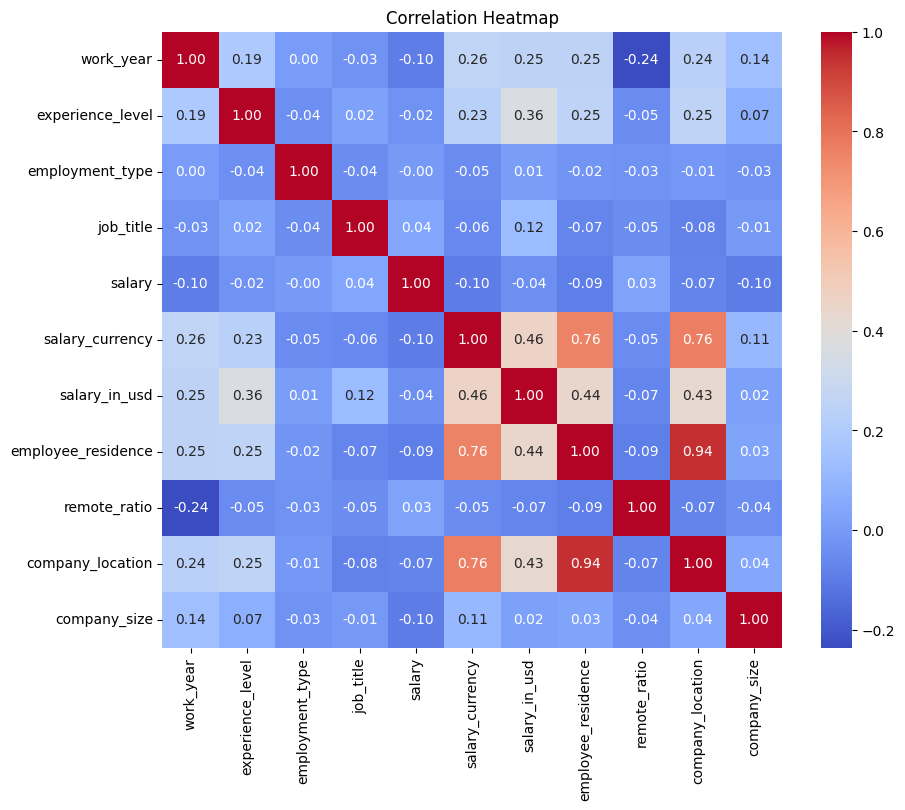

Correlation with Target (salary_in_usd):
salary_in_usd         1.000000
salary_currency       0.459339
employee_residence    0.436646
company_location      0.426759
experience_level      0.364036
work_year             0.250661
job_title             0.123619
company_size          0.016895
employment_type       0.006937
salary               -0.039625
remote_ratio         -0.069823
Name: salary_in_usd, dtype: float64


In [8]:

# Convert Categorical Columns to Numeric Using Label Encoding
# Create a label encoder
label_encoder = LabelEncoder()

# picking the categorical columns
categorical_columns = ['experience_level', 'employment_type', 'job_title', 'salary_currency', 'employee_residence', 'company_location', 'company_size']
for col in categorical_columns:
    data[col] = label_encoder.fit_transform(data[col])


# calculate the correlation matrix
correlation_matrix = data.corr()

## Display the correlation matrix
# print("Correlation Matrix:")
#print(correlation_matrix)

# Plot the heatmap
mat.figure(figsize=(10,8))
se.heatmap(correlation_matrix,
           annot  = True,
           cmap   = 'coolwarm',
           fmt    = '.2f')
mat.title("Correlation Heatmap")
mat.show()

# Correlation with salary_in_usd
correlation_with_target = correlation_matrix['salary_in_usd'].sort_values(ascending=False)
print("Correlation with Target (salary_in_usd):")
print(correlation_with_target)



In [9]:
# Features to drop
columns_to_drop = ['company_size', 'employment_type', 'remote_ratio', 'salary']

# Create X (features) and y (target)
X = data.drop(columns=columns_to_drop + ['salary_in_usd'])
y = data['salary_in_usd']

print("Features Shape:", X.shape)
print("Target Shape:", y.shape)
print(X,y)

Features Shape: (3692, 6)
Target Shape: (3692,)
      work_year  experience_level  job_title  salary_currency  \
0          2023                 3         83                7   
1          2023                 2         65               18   
2          2023                 2         65               18   
3          2023                 3         46               18   
4          2023                 3         46               18   
...         ...               ...        ...              ...   
3749       2021                 3         48               18   
3751       2021                 2         83               18   
3752       2020                 0         46               18   
3753       2020                 0         17               18   
3754       2021                 3         45               11   

      employee_residence  company_location  
0                     26                25  
1                     74                70  
2                     74            

# Normalization

In [10]:
# Normalization
scaler = StandardScaler()
x_scaled = scaler.fit_transform(X)

# Test-Train Split

In [11]:

# Train set - Test set Split
x_train, x_test, y_train, y_test = train_test_split(x_scaled, y, test_size=0.2, random_state=123)

print("\nDataset Shapes:")
print(f"x_train: {x_train.shape}, x_test: {x_test.shape}, y_train: {y_train.shape}, y_test: {y_test.shape}")



Dataset Shapes:
x_train: (2953, 6), x_test: (739, 6), y_train: (2953,), y_test: (739,)


#### Understanding the Shapes

Variable	Shape	Meaning
*   x_train	(2953, 6)	2,953 rows (80%) for training, 6 features
*   x_test	(739, 6)	  739 rows (20%) for testing, 6 features
*   y_train	(2953,)	  2,953 salary values (target) for training
*   y_test	(739,)	    739 salary values (target) for testing






# Linear Regression

In [12]:

model_lr = LinearRegression()

model_lr.fit(x_train, y_train)
y_pred = model_lr.predict(x_test)

# evaluation metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

# Print results
print(f"Linear Regression Performance:")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R² Score: {r2:.2f}")

Linear Regression Performance:
Mean Absolute Error (MAE): 39272.19
Mean Squared Error (MSE): 2454968337.03
Root Mean Squared Error (RMSE): 49547.64
R² Score: 0.29


# Random Forest

In [13]:

model_rf = RandomForestRegressor(n_estimators=200, random_state=123)

model_rf.fit(x_train, y_train)
y_pred = model_rf.predict(x_test)

# evaluation metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)


# Print results
print(f"Random Forest Performance:")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R² Score: {r2:.2f}")

Random Forest Performance:
Mean Absolute Error (MAE): 33876.17
Mean Squared Error (MSE): 1843907677.37
Root Mean Squared Error (RMSE): 42940.75
R² Score: 0.46


# XGBoost

In [14]:

# Initialize XGBoost Regressor
xgb = XGBRegressor(objective='reg:squarederror', random_state=123, n_estimators=200)

# Train the model
xgb.fit(x_train, y_train)

# Predict
y_pred_xgb = xgb.predict(x_test)

# Evaluate Performance
mae = mean_absolute_error(y_test, y_pred_xgb)
mse = mean_squared_error(y_test, y_pred_xgb)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred_xgb)

# Print results
print("XGBoost Performance:")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R² Score: {r2:.2f}")

XGBoost Performance:
Mean Absolute Error (MAE): 34254.74
Mean Squared Error (MSE): 1897937152.00
Root Mean Squared Error (RMSE): 43565.32
R² Score: 0.45


# Comparison: Linear Regression vs Random Forest

```
Linear Regression:
      MAE       : 39,272.19
      MSE       : 2,454,968,337.03
      RMSE      : 49,547.46      
      R² Score  : 0.23

Random Forest:
      MAE       : 33,876.17
      MSE       : 1,843,907,677.37    
      RMSE      : 42,940.75
      R² Score  : 0.46

XGBoost Performance:
      MAE       : 34,254.74
      MSE       : 1,897,937,152.00
      RMSE      : 43,565.32
      R² Score  : 0.45


MAE (Lower is better)	| MSE (Lower is better) |	R² Score (Higher is better)  


--------------------------------------------------------------------------------


*   Mean Absolute Error (MAE) → Measures average absolute difference between predicted & actual salaries. Lower is better.
*   Mean Squared Error (MSE) → Penalizes large errors more. Lower is better.
*   Root Mean Squared Error (RMSE) → More interpretable version of MSE. Lower is better.
*   R² Score (Coefficient of Determination) → Measures how well the model explains salary variation. Higher is better (closer to 1).



**How to Interpret R² Score (Model Accuracy for Regression)**

R² = 1 → Perfect model.
R² > 0.80 → Very good model.
R² ~ 0.50 - 0.70 → Acceptable but can improve.
R² < 0.30 → Weak model, needs improvement.

For example,
if R² = 0.44, it means 44% of salary variation is explained by the model, and 56% remains unexplained.

```



# Hyperparameter Tuning for Random Forest

In [15]:

# Define parameter grid
parameter_grid = {
    "n_estimators": [50, 100, 200],
    "max_depth": [None, 10, 20, 30],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "max_features": ["auto", "sqrt", "log2"]
}



# Initialize the model
rf = RandomForestRegressor(random_state=123)

# Perform Grid Search
_search = GridSearchCV(rf,
                       parameter_grid,
                       scoring= "r2",
                       cv     = 3,
                       n_jobs = -1,
                       verbose= 2)
_search.fit(x_train, y_train)

# Best Model after Grid Search
best_estimator = _search.best_estimator_
best_parameter = _search.best_params_

print(f"Best Parameters: {best_parameter}")
print("\n")


# Evaluate the optimized model
y_pred_rf = best_estimator.predict(x_test)

# Compute evaluation metrics
mae = mean_absolute_error(y_test, y_pred_rf)
mse = mean_squared_error(y_test, y_pred_rf)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred_rf)

# Print results
print("Optimized Random Forest Performance:")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R² Score: {r2:.2f}")
print("\n")


Fitting 3 folds for each of 324 candidates, totalling 972 fits


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
324 fits failed out of a total of 972.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
176 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 1382, in wrapper
    estimator._validate_params()
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.11/dist-packages/sklearn/util

Best Parameters: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}


Optimized Random Forest Performance:
Mean Absolute Error (MAE): 33828.78
Mean Squared Error (MSE): 1832920232.19
Root Mean Squared Error (RMSE): 42812.62
R² Score: 0.47




### Observations

R² Score increased slightly from 0.46 → 0.47, meaning the model explains 47% of salary variation (still needs improvement).